In [4]:
import nltk
import os

# 指定自定義下載目錄
nltk_data_path = os.path.expanduser('~/nltk_data')
if not os.path.exists(nltk_data_path):
    os.makedirs(nltk_data_path)

# 告訴 nltk 在指定目錄中查找資源
nltk.data.path.append(nltk_data_path)

# 下載所需資源
nltk.download('wordnet', download_dir=nltk_data_path)
nltk.download('omw-1.4', download_dir=nltk_data_path)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [5]:
import zipfile
import os

# 解壓縮 wordnet 和 omw-1.4
nltk_data_path = '/root/nltk_data/corpora/'

# 解壓 wordnet.zip
wordnet_zip = os.path.join(nltk_data_path, 'wordnet.zip')
if os.path.exists(wordnet_zip):
    with zipfile.ZipFile(wordnet_zip, 'r') as zip_ref:
        zip_ref.extractall(nltk_data_path)

# 解壓 omw-1.4.zip
omw_zip = os.path.join(nltk_data_path, 'omw-1.4.zip')
if os.path.exists(omw_zip):
    with zipfile.ZipFile(omw_zip, 'r') as zip_ref:
        zip_ref.extractall(nltk_data_path)

print("WordNet and OMw-1.4 have been extracted.")

WordNet and OMw-1.4 have been extracted.


In [6]:
import nltk
from nltk.corpus import wordnet

# 測試 WordNet 是否能夠正常工作
try:
    synonyms = wordnet.synsets("number")
    print("WordNet is working. Found synonyms for 'number':", synonyms)
except Exception as e:
    print("Error loading WordNet:", e)

WordNet is working. Found synonyms for 'number': [Synset('number.n.01'), Synset('number.n.02'), Synset('act.n.04'), Synset('phone_number.n.01'), Synset('numeral.n.01'), Synset('issue.n.02'), Synset('number.n.07'), Synset('number.n.08'), Synset('number.n.09'), Synset('number.n.10'), Synset('number.n.11'), Synset('total.v.01'), Synset('number.v.02'), Synset('number.v.03'), Synset('count.v.05'), Synset('count.v.01'), Synset('number.v.06')]


# Try Attention

In [7]:
import random
import json
import pandas as pd
import numpy as np
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, Dropout, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score
import gensim
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Attention

# Synonym replacement function
def synonym_replacement(text, n=1):
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))

    if len(random_word_list) == 0:
        return text  # Return original text if no synonyms are available

    for _ in range(n):
        word_to_replace = random.choice(random_word_list)
        synonyms = wordnet.synsets(word_to_replace)
        if len(synonyms) > 0:
            synonym = synonyms[0].lemmas()[0].name()
            new_words = [synonym if word == word_to_replace else word for word in new_words]

    return ' '.join(new_words)

# Random insertion function
def random_insertion(text, n=1):
    words = text.split()
    if len(words) == 0:  # Check if the list of words is empty
        return text  # Return original text if empty
    for _ in range(n):
        new_word = random.choice(words)
        insert_position = random.randint(0, len(words))
        words.insert(insert_position, new_word)
    return ' '.join(words)

# Random deletion function
def random_deletion(text, p=0.5):
    words = text.split()
    if len(words) == 0:  # Check if the list of words is empty
        return text  # Return original text if empty
    return ' '.join(word for word in words if random.random() > p)

# Data augmentation function with helpful_vote threshold
def augment_data(texts, titles, labels, helpful_votes, augmentation_factor=2, helpful_vote_threshold=2):
    augmented_texts = []
    augmented_titles = []
    augmented_labels = []

    for text, title, label, helpful_vote in zip(texts, titles, labels, helpful_votes):
        if helpful_vote > helpful_vote_threshold:
            # Skip augmentation for high helpful_vote data
            augmented_texts.append(text)
            augmented_titles.append(title)
            augmented_labels.append(label)
        else:
            # Apply augmentation for lower helpful_vote data
            for _ in range(augmentation_factor):
                aug_type = random.choice(['synonym', 'insertion', 'deletion'])
                if aug_type == 'synonym':
                    aug_text = synonym_replacement(text)
                elif aug_type == 'insertion':
                    aug_text = random_insertion(text)
                elif aug_type == 'deletion':
                    aug_text = random_deletion(text)
                augmented_texts.append(aug_text)
                augmented_titles.append(title)
                augmented_labels.append(label)

    return augmented_texts, augmented_titles, augmented_labels

# Load pre-trained Word2Vec model
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('/kaggle/input/word2vec/GoogleNews-vectors-negative300.bin', binary=True)

# Define function to create embedding matrix
def create_embedding_matrix(word_index, embedding_model, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))  # +1 for padding token (index 0)
    for word, i in word_index.items():
        if word in embedding_model:
            embedding_matrix[i] = embedding_model[word]
        else:
            # For words not in Word2Vec, embedding will be random (optional, otherwise left as 0)
            embedding_matrix[i] = np.random.normal(0, 1, embedding_dim)
    return embedding_matrix

# 定義新的模型架構，加入 Self-Attention
def build_model_with_attention(max_text_length, max_title_length, embedding_matrix_text, embedding_matrix_title):
    # 文本輸入
    text_input = Input(shape=(max_text_length,))
    text_embedding = Embedding(input_dim=embedding_matrix_text.shape[0], 
                               output_dim=embedding_matrix_text.shape[1], 
                               weights=[embedding_matrix_text],
                               trainable=False)(text_input)
    
    # LSTM 層
    text_lstm_1 = Bidirectional(LSTM(64, return_sequences=True))(text_embedding)
    text_attention = Attention()([text_lstm_1, text_lstm_1])  # Self-Attention Layer
    text_lstm_2 = Bidirectional(LSTM(32))(text_attention)

    # 標題輸入
    title_input = Input(shape=(max_title_length,))
    title_embedding = Embedding(input_dim=embedding_matrix_title.shape[0], 
                                output_dim=embedding_matrix_title.shape[1], 
                                weights=[embedding_matrix_title],
                                trainable=False)(title_input)
    title_lstm = Bidirectional(LSTM(32))(title_embedding)

    # 合併輸出
    merged = Concatenate()([text_lstm_2, title_lstm])
    dense_1 = Dense(64, activation='relu')(merged)
    final_output = Dense(5, activation='softmax')(dense_1)  # 5個類別 (評分 1 到 5)

    # 創建模型
    model = Model(inputs=[text_input, title_input], outputs=final_output)
    return model

# Macro F1 Score Callback with model saving and prediction
class MacroF1ScoreCallback(Callback):
    def __init__(self, val_data, test_data):
        super(MacroF1ScoreCallback, self).__init__()
        self.X_text_val, self.X_title_val, self.y_val = val_data
        self.X_test_text, self.X_test_title = test_data
        self.best_f1 = -1

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict([self.X_text_val, self.X_title_val])
        y_pred_mapped = np.argmax(y_pred, axis=1)  # Use argmax for classification output
        
        # Calculate F1 score
        f1 = f1_score(self.y_val, y_pred_mapped, average='macro')
        print(f' - val_macro_f1 (strict): {f1:.4f}')
        
        accuracy = accuracy_score(self.y_val, y_pred_mapped)
        print(f'Validation accuracy: {accuracy:.4f}')

        if f1 > self.best_f1:
            print(f'New best macro F1 score: {f1:.4f}, saving model...')
            self.best_f1 = f1
            self.model.save('best_model.h5')

            y_test_pred = self.model.predict([self.X_test_text, self.X_test_title])
            y_test_rounded = np.argmax(y_test_pred, axis=1) + 1  # Add 1 to match rating scale
            y_test_rounded = np.clip(y_test_rounded, 1, 5)

            submission = pd.read_csv('/kaggle/input/dataseting/sample_submission.csv')
            submission['rating'] = y_test_rounded
            submission.to_csv(f'test_predictions_epoch_{epoch + 1}.csv', index=False)
            print(f"Test predictions saved for epoch {epoch + 1}")

# Load training data
with open('/kaggle/input/dataseting/train.json', 'r') as f:
    train_data = json.load(f)

train_texts = [entry['text'] for entry in train_data]
train_titles = [entry['title'] for entry in train_data]
train_labels = [entry['rating'] - 1 for entry in train_data]  # Convert rating to 0-4 for sparse_categorical_crossentropy
train_helpful_votes = [entry['helpful_vote'] for entry in train_data]  # Extract helpful_vote

# Split data into training and validation sets
X_text_train, X_text_val, X_title_train, X_title_val, y_train, y_val, helpful_votes_train, helpful_votes_val = train_test_split(
    train_texts, train_titles, train_labels, train_helpful_votes, test_size=0.2, random_state=42)

# Augment training data (after split)
augmented_texts, augmented_titles, augmented_labels = augment_data(X_text_train, X_title_train, y_train, helpful_votes_train, augmentation_factor=2, helpful_vote_threshold=10)

# Padding sequences
max_text_length = 300
max_title_length = 15

# Combine original and augmented training data
X_text_train += augmented_texts
X_title_train += augmented_titles
y_train += augmented_labels

# Tokenizer only trained on training data to avoid data leakage
tokenizer_text = Tokenizer()
tokenizer_text.fit_on_texts(X_text_train)  # Fit only on training data

X_text_train_seq = tokenizer_text.texts_to_sequences(X_text_train)
X_text_val_seq = tokenizer_text.texts_to_sequences(X_text_val)

X_text_train_pad = pad_sequences(X_text_train_seq, maxlen=max_text_length, padding='post')
X_text_val_pad = pad_sequences(X_text_val_seq, maxlen=max_text_length, padding='post')

# For title tokenization
tokenizer_title = Tokenizer()
tokenizer_title.fit_on_texts(X_title_train)  # Fit only on training data

X_title_train_seq = tokenizer_title.texts_to_sequences(X_title_train)
X_title_val_seq = tokenizer_title.texts_to_sequences(X_title_val)

X_title_train_pad = pad_sequences(X_title_train_seq, maxlen=max_title_length, padding='post')
X_title_val_pad = pad_sequences(X_title_val_seq, maxlen=max_title_length, padding='post')



# Create embedding matrices for text and title using pre-trained Word2Vec
embedding_dim = 300
embedding_matrix_text = create_embedding_matrix(tokenizer_text.word_index, word2vec_model, embedding_dim)
embedding_matrix_title = create_embedding_matrix(tokenizer_title.word_index, word2vec_model, embedding_dim)

# 使用新的深度模型
model = build_model_with_attention(max_text_length, max_title_length, embedding_matrix_text, embedding_matrix_title)

# 編譯模型
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



# Load test data for predictions
with open('/kaggle/input/dataseting/test.json', 'r') as f:
    test_data = json.load(f)

test_texts = [entry['text'] for entry in test_data]
test_titles = [entry['title'] for entry in test_data]

X_test_text_seq = tokenizer_text.texts_to_sequences(test_texts)
X_test_text_pad = pad_sequences(X_test_text_seq, maxlen=max_text_length, padding='post')

X_test_title_seq = tokenizer_title.texts_to_sequences(test_titles)
X_test_title_pad = pad_sequences(X_test_title_seq, maxlen=max_title_length, padding='post')

# Define validation data and test data for callback
val_data = (X_text_val_pad, X_title_val_pad, np.array(y_val))
test_data = (X_test_text_pad, X_test_title_pad)

# Instantiate the F1 score callback
f1_callback = MacroF1ScoreCallback(val_data=val_data, test_data=test_data)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# 訓練模型
model.fit([X_text_train_pad, X_title_train_pad], np.array(y_train), 
          validation_data=([X_text_val_pad, X_title_val_pad], np.array(y_val)),
          epochs=3, batch_size=16, class_weight=class_weights_dict, callbacks=[f1_callback])

Epoch 1/3
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step
 - val_macro_f1 (strict): 0.5616
Validation accuracy: 0.5689
New best macro F1 score: 0.5616, saving model...
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step
Test predictions saved for epoch 1
5228/5228 ━━━━━━━━━━━━━━━━━━━━ 230s 43ms/step - accuracy: 0.4857 - loss: 1.1660 - val_accuracy: 0.5689 - val_loss: 0.9824
Epoch 2/3
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step
 - val_macro_f1 (strict): 0.5613
Validation accuracy: 0.5714
5228/5228 ━━━━━━━━━━━━━━━━━━━━ 198s 38ms/step - accuracy: 0.6264 - loss: 0.8624 - val_accuracy: 0.5714 - val_loss: 1.0093
Epoch 3/3
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step
 - val_macro_f1 (strict): 0.5658
Validation accuracy: 0.5744
New best macro F1 score: 0.5658, saving model...
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step
Test predictions saved for epoch 3
5228/5228 ━━━━━━━━━━━━━━━━━━━━ 223s 43ms/step - accuracy: 0.6991 - loss: 0.7173 - val_accuracy: 0.5744 - val_loss: 1.0957


# Q2

## Calculate the distribution of the tokenized sequence length

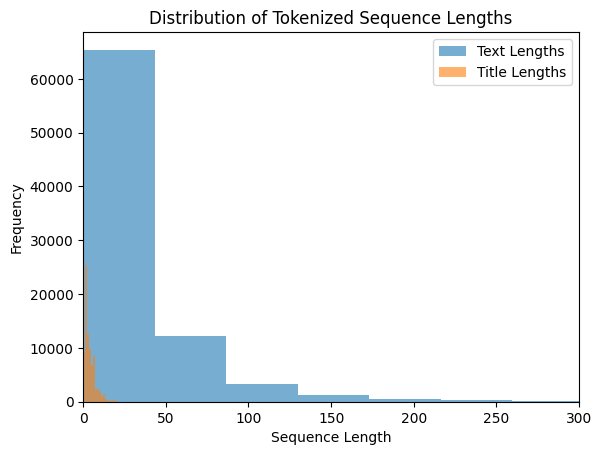

In [9]:
import matplotlib.pyplot as plt

# Calculate the length of each sequence in the training set
text_lengths = [len(seq) for seq in X_text_train_seq]
title_lengths = [len(seq) for seq in X_title_train_seq]

# Plot the distribution of sequence lengths
plt.hist(text_lengths, bins=30, alpha=0.6, label='Text Lengths')
plt.hist(title_lengths, bins=30, alpha=0.6, label='Title Lengths')
plt.title('Distribution of Tokenized Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend()
plt.xlim([0, 300])  # Set x-axis limit from 0 to 300
plt.show()

## Determine the padding size

In [10]:
import numpy as np

# Determine the 95th percentile for text and title lengths
max_text_length = np.percentile(text_lengths, 95)  # Choose the 95th percentile
max_title_length = np.percentile(title_lengths, 95)

# Convert to int as padding sizes need to be integers
max_text_length = int(max_text_length)
max_title_length = int(max_title_length)

print(f"Max text length: {max_text_length}")
print(f"Max title length: {max_title_length}")


Max text length: 105
Max title length: 11
